initial target partials:


,Frequency (Hz),Amplitude
0,73.684211,0.005356
1,136.842105,0.004395
2,147.368421,0.102953
3,223.684211,0.011307
4,297.368421,0.035448
5,371.052632,0.005977
6,442.105263,0.002880
7,447.368421,0.006474
8,521.052632,0.011020
9,594.736842,0.002818


initial target sound:
[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\target_preview_cello_single.wav


initial target sound saved to rendered_audio/target_preview_cello_single.wav


FM 4-osc DE → Manhattan:   0%|           0/500 [ETA: ?, Elapsed: 00:00]


OPTIMAL PARAMETERS (by Oscillator)


,Frequency (Hz),Amplitude
Osc,,
1,9.0,4.352
2,"3,338.2",0.000
3,"2,606.3",6.426
4,"3,213.1",6.382


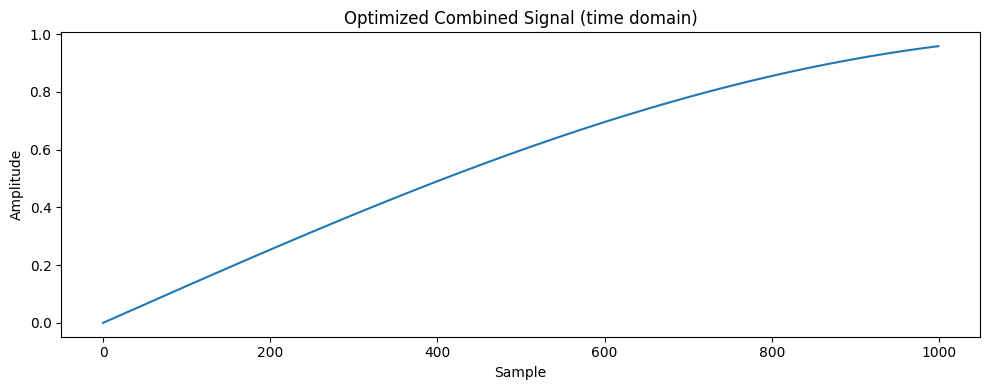

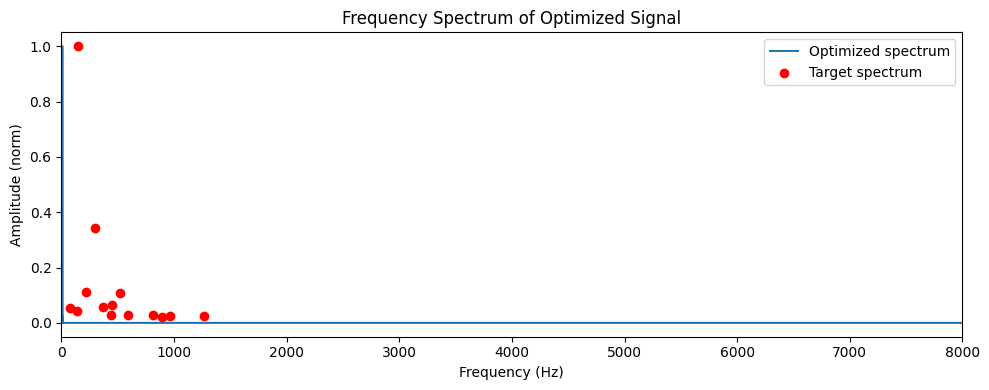

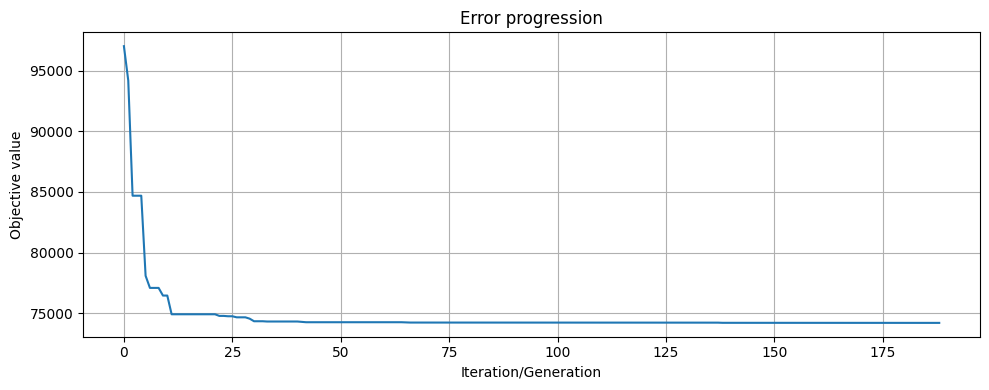

optimized output:
[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_fm_cello_single_de_manhattan_20250906-120935.wav


optimized output saved to rendered_audio\optimized_output_fm_cello_single_de_manhattan_20250906-120935.wav


In [1]:
# --- config & imports ---
import numpy as np
import pandas as pd
from IPython.display import Audio, display
from pathlib import Path

from py_scripts.fm_synth_opt import (
    FMObjective, run_de_optimization, run_basinhopping, run_dual_annealing, synth_chain,
    plot_time, plot_spectrum, plot_error_history, save_wav, synthesize_target_additive
)

# --- deterministic config ---
SR = 44100
DURATION = 1.0
FFT_PAD = 2
METRIC = "manhattan"  # options: "itakura_saito", "spectral_convergence", "cosine", "euclidean", "manhattan", "kl", "pearson", "mfcc"
FADE_IN_MS = 10.0
FADE_OUT_MS = 10.0

# --- load target partials ---
target_path = "tsv/cello_single.tsv"
df = pd.read_csv(target_path, sep="\t")
target_freqs = df["Frequency (Hz)"].to_numpy()
target_amps = (df["Amplitude"] / df["Amplitude"].max()).to_numpy()
target_name = Path(target_path).stem

# --- display initial target partials and audio ---
print("initial target partials:")
display(df)

print("initial target sound:")

_, y_target = synthesize_target_additive(target_freqs, target_amps, DURATION, SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS)
target_wav_path = f"rendered_audio/target_preview_{target_name}.wav"
save_wav(target_wav_path, y_target, sr=SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS)
display(Audio(filename=target_wav_path))
print("initial target sound saved to " + target_wav_path)

# --- build objective (precomputes target spectrum & caches) ---
obj = FMObjective(
    target_freqs, target_amps,
    metric=METRIC, duration=DURATION, sr=SR, fft_pad=FFT_PAD,
    target_kernel="gaussian", target_bw_hz=2.0,  # small spread around each partial
    n_mfcc=20, seed=42
)

bounds = obj.default_bounds(freq_lo=5.0, freq_hi=5000.0, amp_lo=0.0, amp_hi=10.0)

# --- optimize (parallel if you want) ---
# workers=-1 uses ALL available cores on de

result, history = run_de_optimization(
    obj, bounds, maxiter=500, popsize=15, tol=1e-6,
    mutation=(0.5, 1.0), recombination=0.7, strategy="best1bin",
    workers=-1, seed=42
)

# result, history = run_dual_annealing(obj, bounds, maxiter=500, seed=42)

# result, history = run_basinhopping(obj, bounds, maxiter=500, stepsize=0.4, seed=42)

params = result.x

# Nicely formatted optimal params (by oscillator)
print("\n" + "="*50)
print("OPTIMAL PARAMETERS (by Oscillator)")
print("="*50)

# params layout: [f4, a4, f3, a3, f2, a2, f1, a1]
osc_rows = [
    {"Osc": 1, "Frequency (Hz)": params[6], "Amplitude": params[7]},
    {"Osc": 2, "Frequency (Hz)": params[4], "Amplitude": params[5]},
    {"Osc": 3, "Frequency (Hz)": params[2], "Amplitude": params[3]},
    {"Osc": 4, "Frequency (Hz)": params[0], "Amplitude": params[1]},
]

osc_df = pd.DataFrame(osc_rows).set_index("Osc").sort_index()

# Display formatted values
fmt_df = osc_df.copy()
fmt_df["Frequency (Hz)"] = fmt_df["Frequency (Hz)"].map(lambda v: f"{v:,.1f}")
fmt_df["Amplitude"] = fmt_df["Amplitude"].map(lambda v: f"{v:,.3f}")
display(fmt_df)

# --- synthesize, plot, and save ---
t, y = synth_chain(params, duration=DURATION, sr=SR)
plot_time(y, sr=SR)
plot_spectrum(y, sr=SR, target_freqs=target_freqs, target_amps=target_amps, xlim=(0, 8000), fft_pad=FFT_PAD)
plot_error_history(history)

print("optimized output:")

out_path = f"rendered_audio/optimized_output_fm_{target_name}.wav"
out_path = save_wav(out_path, y, sr=SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS, add_info=True, add_time=True)
display(Audio(filename=out_path))
print("optimized output saved to " + out_path)

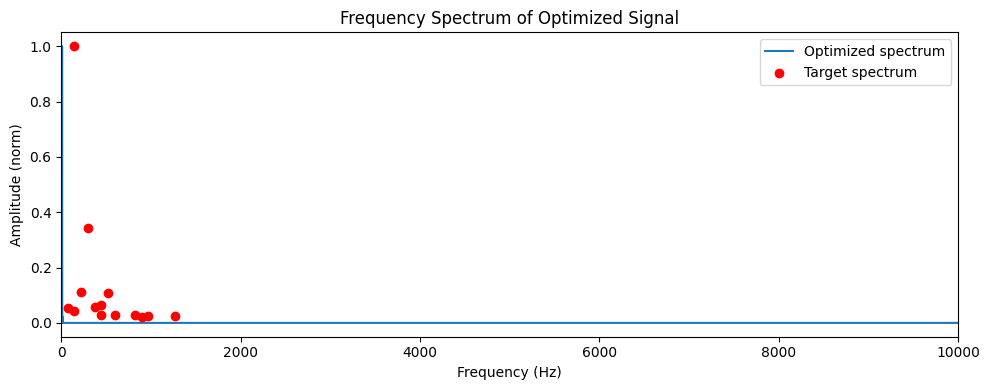

In [5]:
plot_spectrum(y, sr=SR, target_freqs=target_freqs, target_amps=target_amps, xlim=(0, 10000), fft_pad=FFT_PAD, show=False)

In [3]:
# Render 10-second optimized audio
from IPython.display import Audio, display
LONG_DURATION = 10.0
out_path_long = f"rendered_audio/optimized_output_fm_{target_name}_long_{LONG_DURATION:.1f}s.wav"
t_long, y_long = synth_chain(params, duration=LONG_DURATION, sr=SR)
out_path_long = save_wav(out_path_long, y_long, sr=SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS, add_info=True, add_time=True)
display(Audio(filename=out_path_long))
print(f"{LONG_DURATION:.1f}s optimized output saved to {out_path_long}")


[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_fm_cello_single_long_10.0s_de_manhattan_20250906-120935.wav


10.0s optimized output saved to rendered_audio\optimized_output_fm_cello_single_long_10.0s_de_manhattan_20250906-120935.wav


In [4]:
from py_scripts.fm_synth_opt import save_and_display_final_values, LAST_METHOD, LAST_METRIC
from datetime import datetime

suffix = f"{LAST_METHOD}_{LAST_METRIC}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tsv_path = f"tsv/final_values_fm_{target_name}_{suffix}.tsv"
save_and_display_final_values(params, tsv_path)

TSV file was saved at: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\tsv\final_values_fm_cello_single_de_manhattan_20250906-120935.tsv


,Modulator,Frequency (Hz),Amplitude
0,1,8.999956,4.352244e+00
1,2,3338.187023,2.304088e-07
2,3,2606.284488,6.425968e+00
3,4,3213.121398,6.381659e+00
